# Bayesian Optimization Example Using `mlos_core`

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import toml
import ConfigSpace as CS

In [2]:
from endure.lsm.cost import EndureCost
from endure.lsm.types import LSMDesign, System, Policy, Workload, LSMBounds


In [3]:
with open("endure.toml") as fid:
        config = toml.load(fid)
bounds: LSMBounds = LSMBounds(**config["lsm"]["bounds"])
cf: EndureCost = EndureCost(bounds.max_considered_levels)

In [4]:
system = System(E = 1024, s = 1.905581e-8, B = 64.0, N = 522365629, H = 5.705814, phi = 1.0)
workload = Workload(z0 = 0.063, z1 = 0.190, q = 0.545, w = 0.202)
num_k_values = config["job"]["BayesianOptimization"]["num_k_values"]

In [5]:
# file_dir = os.path.dirname(__file__)
# config_path = os.path.join(file_dir, "endure.toml")


In [6]:
# Define a fake "performance" function.
# In an actual application, we would not have access to this function directly.
# Instead, we could only measure the outcome by running an experiment, such as timing
# a particular run of the system.
def f(design: LSMDesign, system: System, workload: Workload):
    return cf.calc_cost(
                design,
                system,
                workload.z0,
                workload.z1,
                workload.q,
                workload.w,
            )
    # return (6*x-2)**2*np.sin(12*x-4)

In [7]:
# # define a domain to evaluate
# line = np.linspace(0, 1)
# # evaluate the function
# values = f(line)
# # plot the function
# plt.plot(line, values)
# plt.xlabel("Input (parameter)")
# plt.ylabel("Objective (i.e. performance)")

In [8]:
def define_config_space(num_k_values, system, bounds):
    input_space = CS.ConfigurationSpace(seed=1234)
    # input_space.add_hyperparameter(CS.CategoricalHyperparameter("policy", ["Tiering", "Leveling", "Classic", "KHybrid", "QFixed", "YZHybrid"]))

    input_space.add_hyperparameter(CS.UniformFloatHyperparameter(name='h', lower=bounds.bits_per_elem_range[0], 
                                                                 upper=min(np.floor(system.H), bounds.bits_per_elem_range[1])))

    input_space.add_hyperparameter(CS.UniformIntegerHyperparameter(name='t', lower=bounds.size_ratio_range[0], 
                                                                 upper=bounds.size_ratio_range[1]))
    for i in range(num_k_values):
        input_space.add_hyperparameter(
            CS.UniformIntegerHyperparameter(
                name=f'k_{i}',
                lower=1,
                upper=bounds.size_ratio_range[1] - 1
            )
        )

    return input_space

In [9]:
import mlos_core.optimizers

In [10]:
# Choose an optimizer.

#optimizer = mlos_core.optimizers.RandomOptimizer(parameter_space=input_space)

#optimizer = mlos_core.optimizers.FlamlOptimizer(parameter_space=input_space)
input_space = define_config_space(num_k_values, system, bounds)
optimizer = mlos_core.optimizers.SmacOptimizer(parameter_space=input_space) # , seed=42, n_random_init=20)

In [11]:
# Inspect the chosen optimizer
optimizer

SmacOptimizer(space_adapter=None)

In [12]:
n_iterations=15

Now, we can run the actual optimization which will carry out the steps outlined above.

In [13]:
# def run_optimization(optimizer: mlos_core.optimizers.BaseOptimizer):
#     # get a new config value suggestion to try from the optimizer.
#     suggested_value = optimizer.suggest()
#     print(suggested_value)
#     # suggested value are dictionary-like, keys are input space parameter names
#     # evaluate target function
#     target_value = f(suggested_value['x'])
#     print(suggested_value, "\n", target_value)
#     optimizer.register(suggested_value, target_value)

# # run for some iterations
# n_iterations = 15
# for i in range(n_iterations):
#     run_optimization(optimizer)

# def run_optimization(optimizer):
#     suggested_config = optimizer.suggest()  
    
    # design = LSMDesign(h=suggested_config['h'], T=suggested_config['t'], K=[suggested_config[f'k_{i}'] for i in range(num_k_values)])
    # print(design)
    # h = np.array(suggested_config['h']) if isinstance(suggested_config['h'], pd.Series) else design.h
    # T = np.array(suggested_config['t']) if isinstance(suggested_config['t'], pd.Series) else design.T
    # k_values = [suggested_config[f'k_{i}'].iloc[0] for i in range(num_k_values)]

    # print(k_values)
    # cost = f(LSMDesign(h=h[0], T=T[0], K=k_values), system, workload)
    # optimizer.register(suggested_config, cost)
    
import pandas as pd

# def run_optimization(optimizer):
#     suggested_config = optimizer.suggest()

#     h = suggested_config['h'].iloc[0] if isinstance(suggested_config['h'], pd.Series) else suggested_config['h']
#     T = suggested_config['t'].iloc[0] if isinstance(suggested_config['t'], pd.Series) else suggested_config['t']
#     k_values = [suggested_config[f'k_{i}'].iloc[0] 
#                 if isinstance(suggested_config[f'k_{i}'], pd.Series) 
#                 else suggested_config[f'k_{i}'] for i in range(num_k_values)]
#     design = LSMDesign(h=h, T=T, K=k_values)
#     cost = f(design, system, workload)
#     params_dict = {'h': [h], 't': [T]}
#     params_dict.update({f'k_{i}': [k_values[i]] for i in range(len(k_values))})
#     params_df = pd.DataFrame(params_dict)

#     optimizer.register(params_df, pd.Series([cost]))

# for _ in range(n_iterations):
#     run_optimization(optimizer)

def run_optimization(optimizer):
    suggested_config = optimizer.suggest()
    h = suggested_config['h'].iloc[0] if isinstance(suggested_config['h'], pd.Series) else suggested_config['h']
    T = suggested_config['t'].iloc[0] if isinstance(suggested_config['t'], pd.Series) else suggested_config['t']
    k_values = [suggested_config[f'k_{i}'].iloc[0] if isinstance(suggested_config[f'k_{i}'], pd.Series) else suggested_config[f'k_{i}'] for i in range(num_k_values)]

    design = LSMDesign(h=h, T=T, K=k_values)
    cost = f(design, system, workload)

    config_data = {
        'h': [h],
        't': [T]
    }
    config_data.update({f'k_{i}': [k_values[i]] for i in range(len(k_values))})
    config_df = pd.DataFrame(config_data)
    score_series = pd.Series([cost])
    optimizer.register(config_df, score_series)

for _ in range(n_iterations):
    run_optimization(optimizer)



After 15 iterations, the model is likely to have captured the general shape, but probably not have found the actual optimum since the first few iterations are spent randomly exploring the space.

In [14]:
optimizer.get_observations()

,h,t,k_0,k_1,k_2,k_3,k_4,k_5,k_6,k_7,...,k_11,k_12,k_13,k_14,k_15,k_16,k_17,k_18,k_19,score
0,3.737656,8,29,25,4,1,28,24,15,14,...,21,4,22,3,11,15,25,27,24,2.011905
0,2.336560,25,4,12,28,19,1,5,21,22,...,14,16,1,30,19,23,10,8,10,1.410573
0,1.649137,17,18,20,12,28,22,12,7,27,...,8,26,29,18,29,21,7,3,22,1.486080
0,4.300109,15,15,6,18,14,12,17,27,5,...,30,8,10,15,7,4,20,22,5,1.729050
0,4.531819,2,21,13,26,9,14,21,26,23,...,24,4,26,20,25,29,4,16,19,5.718406
0,1.386161,30,9,30,5,26,16,8,2,2,...,2,23,13,9,4,9,16,4,1,1.345168
0,2.573706,24,25,1,20,21,6,2,18,10,...,8,27,19,5,15,5,28,14,28,1.430656
0,3.469244,11,5,17,11,7,26,27,8,19,...,16,15,5,25,23,19,15,25,15,1.777218
0,3.155933,29,17,4,22,29,14,14,29,27,...,13,11,25,22,24,2,13,30,3,1.426274
0,2.801109,4,12,17,9,13,18,19,5,3,...,21,24,14,11,2,23,29,11,17,2.690642


In [15]:
# # evaluate the surrogate function
# #
# configs = pd.DataFrame(line.reshape(-1, 1), columns=['x'])
# surrogate_predictions = optimizer.surrogate_predict(configs)

# # plot the observations
# #
# observations = optimizer.get_observations()
# plt.scatter(observations.x, observations.score, label='observed points')

# # plot the true function (usually unknown)
# #
# plt.plot(line, values, label='true function')

# # plot the surrogate
# #
# # alpha = optimizer_config.experiment_designer_config.confidence_bound_utility_function_config.alpha
# # t_values = t.ppf(1 - alpha / 2.0, surrogate_predictions['predicted_value_degrees_of_freedom'])
# # ci_radii = t_values * np.sqrt(surrogate_predictions['predicted_value_variance'])
# # value = surrogate_predictions['predicted_value']
# plt.plot(line, surrogate_predictions, label='surrogate predictions')
# #plt.fill_between(line, value - ci_radii, value + ci_radii, alpha=.1)
# #plt.plot(line, -optimizer.experiment_designer.utility_function(optimization_problem.construct_feature_dataframe(pd.DataFrame({'x': line}))), ':', label='utility_function')
# plt.ylabel("Objective function f (performance)")
# plt.xlabel("Input variable")
# plt.legend()
# plt.show()

We can find the best value according to the current surrogate with the ``optimum`` method:

In [16]:
optimizer.get_best_observation()

,h,t,k_0,k_1,k_2,k_3,k_4,k_5,k_6,k_7,...,k_11,k_12,k_13,k_14,k_15,k_16,k_17,k_18,k_19,score
0,1.386161,30,9,30,5,26,16,8,2,2,...,2,23,13,9,4,9,16,4,1,1.345168


We can run more iterations to improve the surrogate model and the optimum that is found:

In [17]:
# run for more iterations
n_iterations = 50
for i in range(n_iterations):
    run_optimization(optimizer)

There is some improvement in the optimum:

In [18]:
best = optimizer.get_best_observation()

In [19]:
h = best['h'].iloc[0] if isinstance(best['h'], pd.Series) else best['h']
T = best['t'].iloc[0] if isinstance(best['t'], pd.Series) else best['t']
k_values = [best[f'k_{i}'].iloc[0] if isinstance(best[f'k_{i}'], pd.Series) else best[f'k_{i}'] for i in range(num_k_values)]

design = LSMDesign(h=h, T=T, K=k_values)
cost = f(design, system, workload)

In [20]:
from endure.lsm.solver.klsm_solver import KLSMSolver

def find_analytical_results(system: System, workload: Workload, bounds: LSMBounds):
    solver = KLSMSolver(bounds)
    z0, z1, q, w = workload.z0, workload.z1, workload.q, workload.w
    nominal_design, nominal_solution = solver.get_nominal_design(system, z0, z1, q, w)
    k_values = nominal_design.K    
    scalars = np.array([nominal_design.h, nominal_design.T])
    all_values = np.concatenate((scalars, k_values))

    cost_ana = solver.nominal_objective(all_values, system, z0, z1, q, w)
    
    print("Cost for the nominal design using analytical solver:", cost_ana)
    print("Cost for the MLOS design using analytical solver:", cost)
    print("Nominal Design suggested by analytical solver:", nominal_design)
    
    return nominal_design, cost



In [21]:
cost
design_ana, cost_ana = find_analytical_results(system, workload, bounds)

Cost for the nominal design using analytical solver: 1.3324805758920721
Cost for the MLOS design using analytical solver: 1.3325045814411611
Nominal Design suggested by analytical solver: LSMDesign(h=1.0000000000000007, T=30.999999999999996, policy=<Policy.KHybrid: 3>, Q=1.0, Y=1.0, Z=1.0, K=array([1.        , 1.        , 1.35101038, 3.9684263 , 7.14416367,
       6.66123056, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]))


We can now visualize the surrogate model and optimization process again. The points are colored according to the iteration number, with dark blue points being early in the process and yellow points being later. You can see that at the end of the optimization, the points start to cluster around the optimum.
The region to the right is not explored much because the surrogate model predicts that it is not likely to contain the optimum and hence also doesn't have as much accuracy compared to the real function there.

In [22]:
n_runs = 100
n_iterations = 50

In [23]:
from endure.lcm.data.generator import KHybridGenerator
generator = KHybridGenerator(bounds)
mlos_costs = []
analytical_costs = []
for i in range(n_runs):
    print(f"Iteration {i + 1}/{n_runs} running")
    system = generator._sample_system()
    z0, z1, q, w = generator._sample_workload(4)
    workload = Workload(z0=z0, z1=z1, q=q, w=w)
    input_space = define_config_space(num_k_values, system, bounds)
    optimizer = mlos_core.optimizers.SmacOptimizer(parameter_space=input_space) # , seed=42, n_random_init=20)
    for _ in range(n_iterations):
        run_optimization(optimizer)
    best = optimizer.get_best_observation()
    h = best['h'].iloc[0] if isinstance(best['h'], pd.Series) else best['h']
    T = best['t'].iloc[0] if isinstance(best['t'], pd.Series) else best['t']
    k_values = [best[f'k_{i}'].iloc[0] if isinstance(best[f'k_{i}'], pd.Series) else best[f'k_{i}'] for i in range(num_k_values)]

    design = LSMDesign(h=h, T=T, K=k_values)
    cost = f(design, system, workload) 
    mlos_costs.append(cost)
    design_ana, cost_ana = find_analytical_results(system, workload, bounds)
    analytical_costs.append(cost_ana)

Iteration 1/100 running
Cost for the nominal design using analytical solver: 3.514121443186608
Cost for the MLOS design using analytical solver: 3.5141355950467594
Nominal Design suggested by analytical solver: LSMDesign(h=1.0000000000000007, T=31.0, policy=<Policy.KHybrid: 3>, Q=1.0, Y=1.0, Z=1.0, K=array([1.        , 1.        , 1.01459844, 3.58295232, 5.99025824,
       9.84843676, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]))
Iteration 2/100 running
Cost for the nominal design using analytical solver: 0.9153575646295251
Cost for the MLOS design using analytical solver: 0.9162821036848784
Nominal Design suggested by analytical solver: LSMDesign(h=5.168359708847555, T=16.386147404477825, policy=<Policy.KHybrid: 3>, Q=1.0, Y=1.0, Z=1.0, K=array([1.        , 1.        , 1.        , 1.49811538, 2.73440029,
       1.        , 1.        , 1.        , 1.

In [24]:
normalized_differences = [(ana - mlos) / ana if ana != 0 else 0 for mlos, ana in zip(mlos_costs, analytical_costs)]


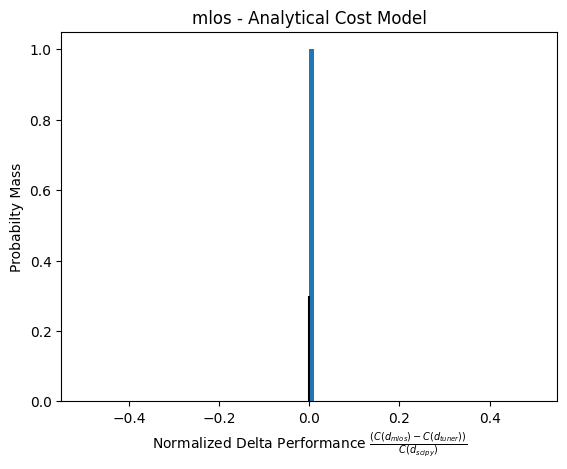

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# fig, ax = plt.subplots()
# ax.hist(normalized_differences, bins=20, alpha=0.75, color='tab:blue', edgecolor='black')
# ax.set_ylabel('Frequency')
# ax.set_xlabel('Normalized Delta Performance $\\frac{C(d_{MLOs}) - C(d_{analytical})}{C(d_{analytical})}$')
# ax.set_title('Performance Difference Between MLOs and Analytical Costs')
# ax.axvline(x=0, color='red', linestyle='dashed', linewidth=1)  # Marking the zero line

# plt.show()
data = normalized_differences
fig, ax = plt.subplots()
ax.hist(data, bins=100, weights=np.ones_like(data)/len(data), alpha=1, density=False, label='ACM', color='tab:blue')
ax.set_ylabel('Probabilty Mass')
ax.set_xlabel('Normalized Delta Performance $\\frac{(C(d_{mlos}) - C(d_{tuner}))}{C(d_{scipy})}$')
ax.set_title('mlos - Analytical Cost Model')
ax.vlines(x=0, ymin=0, ymax=0.3, color='black')
# ax.vlines(x=-0.1, ymin=0, ymax=0.3, color='black')
# ax.legend()
plt.show()